# RAMP Starting Kit on Shape and Patterns classification challenge


# Introduction

In the dynamic world of robotics, the integration of cutting-edge sensing and perception technologies is crucial for unlocking new capabilities and functionalities. Whether navigating complex environments or interacting with objects, the ability to recognize shapes empowers robots to make intelligent decisions and perform tasks with accuracy.

To address these challenges, we aim to explore the potential of AI-image recognition using the geometric shape dataset, ShapeDetector.
This dataset comprises 13 distinct geometric shapes, including circles, hexagons, rectangles, and more, as illustrated below.

The objective of this challenge is to develop machine learning models capable of accurately classifying these geometric shapes. By leveraging the ShapeDetector dataset, we seek to advance the field of robotics and pave the way for enhanced perception and decision-making capabilities in robotic systems.

Another aspect of this challenge involves exploring possibilities for data augmentation. This process enhances the dataset by introducing variations to the images, such as adding noise, blurring, displacement, and rotation.
 By augmenting the data in this way, we can improve the robustness and generalization ability of machine learning models trained on the dataset.


For more information on ShapeDetector and its elements, please visit: [https://universe.roboflow.com/mflyyoloseg/shapedetector
]

Let's embark on this journey together to unlock the potential of AI-image recognition in shaping the future of robotics!



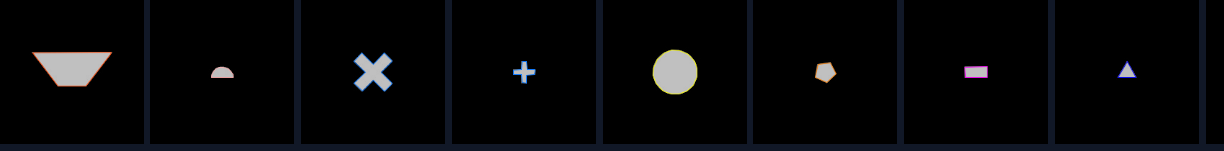



# Table of contents
1. [Import data](#Import_data)
    
2. [Data Exploration](#data_exp)
    1. [Surface area distribution](#sad)
    2. [Mean image](#2)
    3. [Symmetry](#3)
    4. [Perimeter](#4)
    5. [Kmeans](#5)

3. [Data Augumentation](#Data_Aug)
    1. [Adding some blurring](#6)
    2. [Adding some noise](#7)
    3. [A way to deblur images](#8)
    4. [Rotate the image](#9)
    5. [Move the image](#10)
    6. [Classe ImageK](#11)
    
4. [Basic Classifier](#classifier)
5. [Submission](#Submission)

## Requirements

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
import random
import itertools as it
import functools

# 1. Import Data <a class="anchor" id="Import Data"></a>
Data consist of  grey-scale images of geometric shapes with a total of 13 target labels.


In [2]:
# Load the npz file
data_train= np.load("data/train_data_1.npz")
data_test=np.load("data/test_data_1.npz")
# Access the arrays
X_train = data_train["xtrain"]
y_train = data_train["ytrain"]
X_test = data_test["xtest"]
y_test = data_test["ytest"]

In [5]:
# Read csv
train_df = pd.read_csv("data/train/_classes.csv", sep=', ', engine="python")

# Mapping int to categories
CLASSES = train_df.columns[1:]
CLASSES_INT = np.arange(len(CLASSES))
cat_to_int = dict(list(zip(CLASSES,CLASSES_INT)))
int_to_cat = dict(list(zip(CLASSES_INT,CLASSES)))
cat_to_int

{'circle': 0,
 'cross': 1,
 'heptagon': 2,
 'hexagon': 3,
 'octagon': 4,
 'pentagon': 5,
 'quartercircle': 6,
 'rectangle': 7,
 'semicircle': 8,
 'square': 9,
 'star': 10,
 'trapezoid': 11,
 'triangle': 12}

Now we can work with `X_train` and `y_train`.



# 2.  Data exploration <a name=data_exp></a>
We propose several approaches to explore the data, like surface area distribution, symmetry, uniformity, and kmeans representation.


### 2.1 Surface area distribution <a class="anchor" id="sad"></a> [↑](#Table-of-contents)


In [6]:
# Number of white pixels of each image
white_pixels = np.sum(X_train != 0,axis=(1,2))

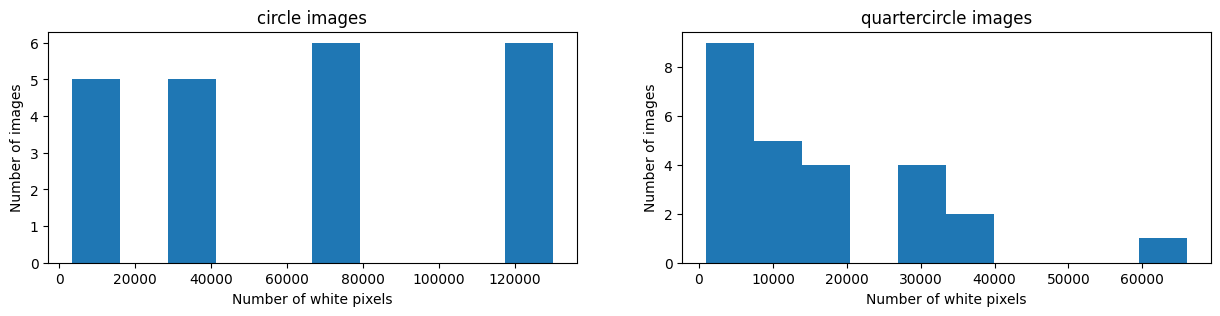

In [7]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

fig, ax = plt.subplots(1,2,figsize=(15, 3))
ax[0].hist(white_pixels[select1])
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[0].set_xlabel("Number of white pixels")
ax[0].set_ylabel("Number of images")

ax[1].hist(white_pixels[select2])
ax[1].set_title(f'{int_to_cat[cat2]} images')
ax[1].set_xlabel("Number of white pixels")
ax[1].set_ylabel("Number of images")

plt.show()

In [ ]:
# à commenter
# un cercle ça a 4 fois plus de surface qu'un quart de cercle typiquement

### 2.2 Mean image <a class="anchor" id="2"></a> [↑](#Table-of-contents)

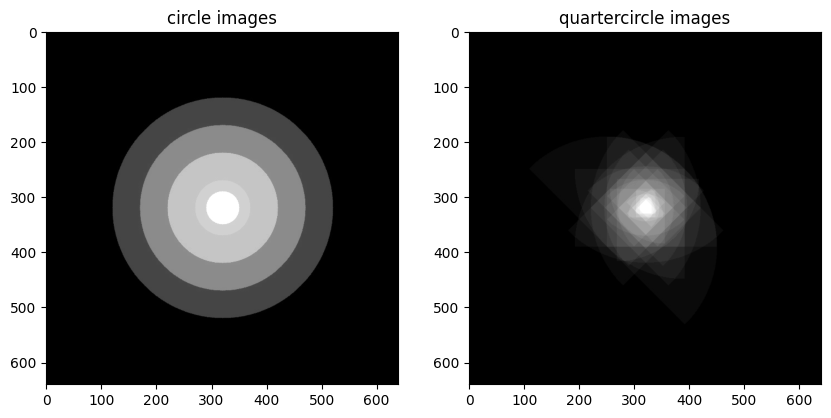

In [8]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

mean_img1 = X_train[select1].mean(axis=0)
mean_img2 = X_train[select2].mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(mean_img1, cmap='gray')
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[1].imshow(mean_img2, cmap='gray')
ax[1].set_title(f'{int_to_cat[cat2]} images')
plt.show()

In [ ]:
# à commenter
# pistes à commenter :

# simply need to overcome rotation, dilatation (on va pas le faire pour ne pas donner une solution toute faite)

### 2.3 Symmetry <a class="anchor" id="3"></a> [↑](#Table-of-contents)

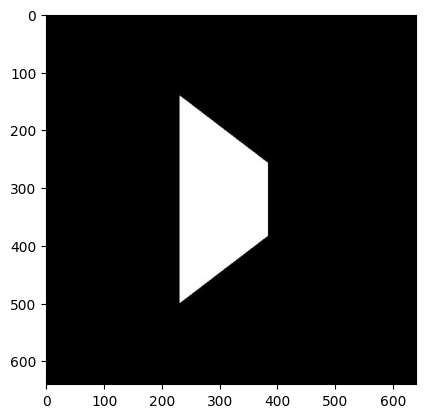

In [9]:
index = 3
Z = X_train[index]
plt.imshow(Z, cmap='gray')

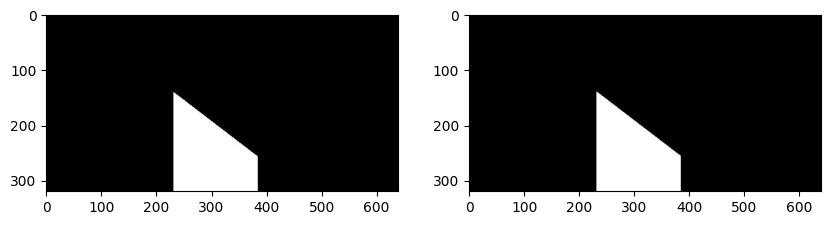

In [10]:
up, down = np.split(Z,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray')
ax[1].imshow(np.flip(down,0), cmap='gray')
plt.show()

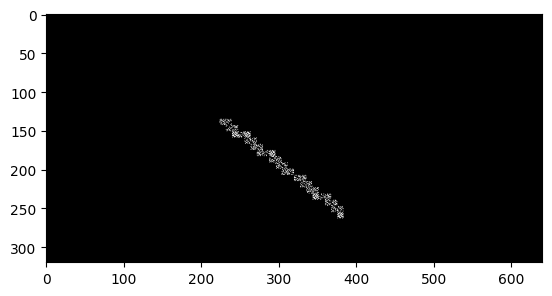

In [11]:
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

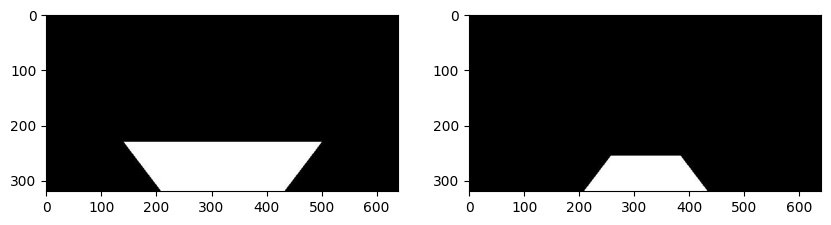

In [12]:
up, down = np.split(Z.T,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray')
ax[1].imshow(np.flip(down,0), cmap='gray')
plt.show()

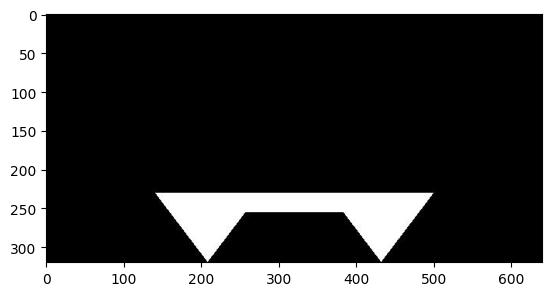

In [13]:
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

In [ ]:
# à commenter
# certaines formes sont symétriques horizontalement ou verticalement
# n'est pas robuste à la rotation
# permet separer cercle, rectangles, croix du reste typiquement

## 2.4 Perimeter <a class="anchor" id="4"></a> [↑](#Table-of-contents)

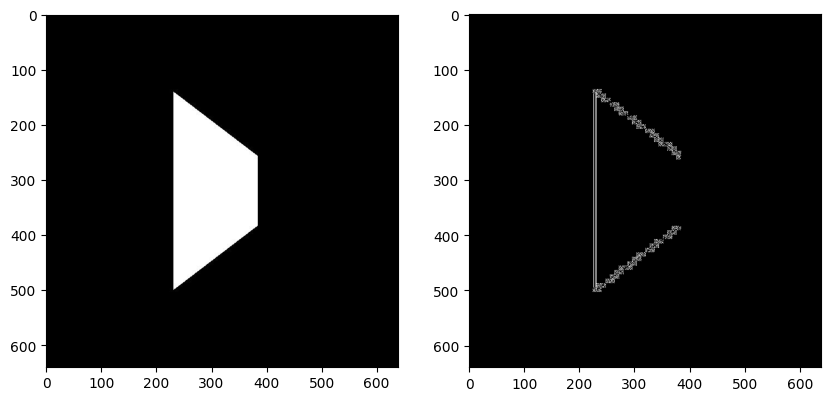

In [14]:
index = 3

Z = X_train[index]
Z_perimeter = np.diff(Z)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[1].imshow(Z_perimeter, cmap='gray')
plt.show()

In [ ]:
# à commenter
# jsp à quoi ça peut servir ^^'
# en vrai, une classe de forme pourrait se définir à travers sa surface et son périmètre
# (tant qu'on arrive à surmonter la dilatation bien sûr)

## 2.5 Kmeans <a class="anchor" id="5"></a> [↑](#Table-of-contents)

In [15]:
# Pour faire du kmeans
from sklearn.cluster import KMeans

def kmeans(X,K=4):

    kmeansX = KMeans(n_clusters=K,max_iter=10).fit(X)
    label = kmeansX.labels_
    center = kmeansX.cluster_centers_
    res = center[kmeansX.labels_]

    return (res,label,center)

On fait du kmeans sur chaque ligne (et colonne) de l'image. Cela nous donne une sorte de convolution :

L'image est résumée en K types de bandes diponibles dans `center`, dont le label est enregistré dans `label`. L'image finale est accessible à travers `res`.

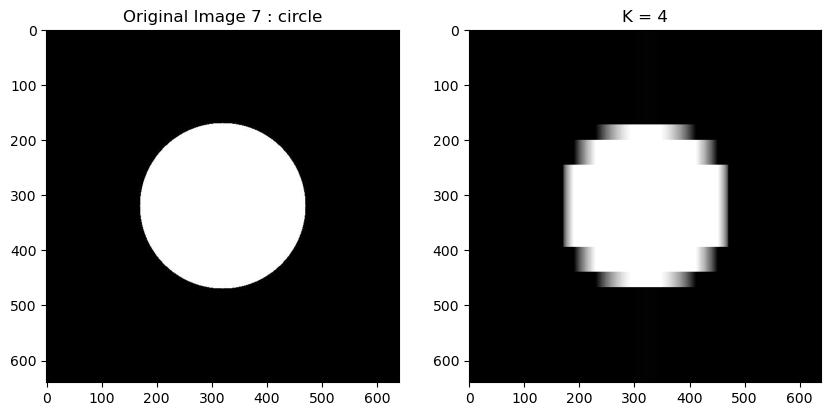

In [ ]:
index = 7
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the image
Z = X_train[index]
# Get the category
cat = y_train[index]

if transpose:
    Z = np.transpose(Z)

res,label,center = kmeans(Z,K)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray')
ax[1].set_title(f'K = {K}')
plt.show()

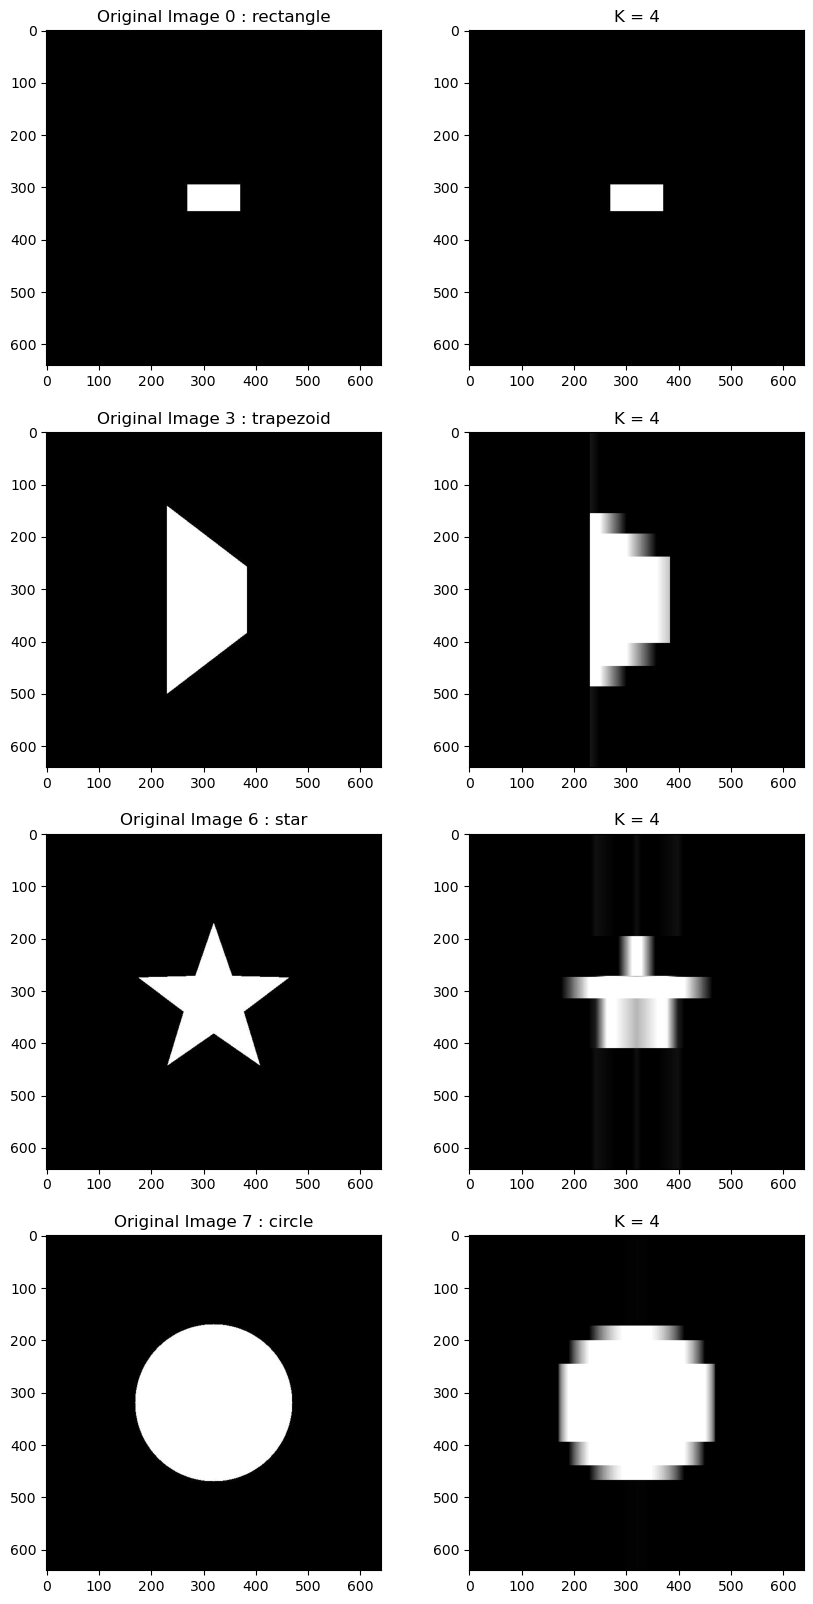

In [ ]:
indexes = [0,3,6,7]
n_indexes = len(indexes)
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the images
Z_selected = X_train[indexes]

fig, ax = plt.subplots(n_indexes,2,figsize=(10, n_indexes*5))

for i,index in enumerate(indexes):

    # Get the image
    Z = X_train[index]
    # Get the category
    cat = y_train[index]

    if transpose:
        Z = np.transpose(Z)

    res,label,center = kmeans(Z,K)

    ax[i,0].imshow(Z, cmap='gray')
    ax[i,0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
    ax[i,1].imshow(res, cmap='gray')
    ax[i,1].set_title(f'K = {K}')

plt.show()

In [ ]:
# à commenter!!
# pistes intéressantes à commenter :

# comparaison à l'image de base : une étoile est extrement déformée même pour un K grand
# comparaison des bandes entre elles
# comparaison des bandes entre catégorie
# permet de réduire la taille des images (640*640 pour pas tant d'information que ça...)

# 3. Data Augumentation <a class="anchor" id="Data_aug"></a>
As the test data has only 44 images, proceeding with data augumenatation will help with stronger more robust classification results.
In this section we proceed with some suggetions of data augumentation techniques.

### 3.1 Adding some blurring <a class="anchor" id="6"></a> [↑](#Table-of-contents)

In [16]:
from PIL import Image, ImageFilter

def blur_image(img, radius=2):
    """
    Blur the input image and save the result to the output path.

    Args:
    img (PIL.Image): Input image.
    radius (int): Blur radius. Higher values result in more blurring.

    Returns:
    PIL.Image: Blurred image.
    """
    # Apply the blur filter
    blurred_image = img.filter(ImageFilter.GaussianBlur(radius))

    return blurred_image

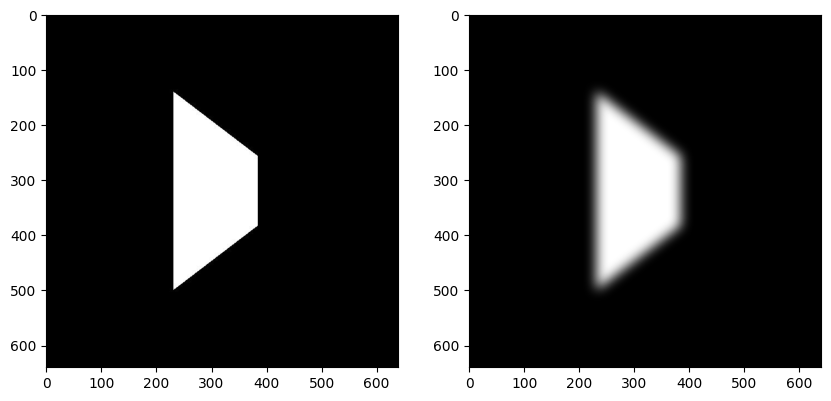

In [17]:
index = 3
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# You can also go back to np array representation with np.array(img)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(blurred_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

### 3.2 Adding some noise <a class="anchor" id="7"></a> [↑](#Table-of-contents)


In [18]:
def add_noise(image, mean=0, std_dev=1):
    """
    Add Gaussian noise to the given image.

    Args:
    image (PIL.Image): Input image.
    mean (float): Mean of the Gaussian noise distribution.
    std_dev (float): Standard deviation of the Gaussian noise distribution.

    Returns:
    PIL.Image: Image with added Gaussian noise.
    """
    # Convert image to numpy array
    img_array = np.array(image)

    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, img_array.shape).astype(np.uint8)

    # Add noise to the image
    noisy_image = np.clip(img_array + noise, 0, 255).astype(np.uint8)

    # Convert back to PIL image
    noisy_image = Image.fromarray(noisy_image)

    return noisy_image

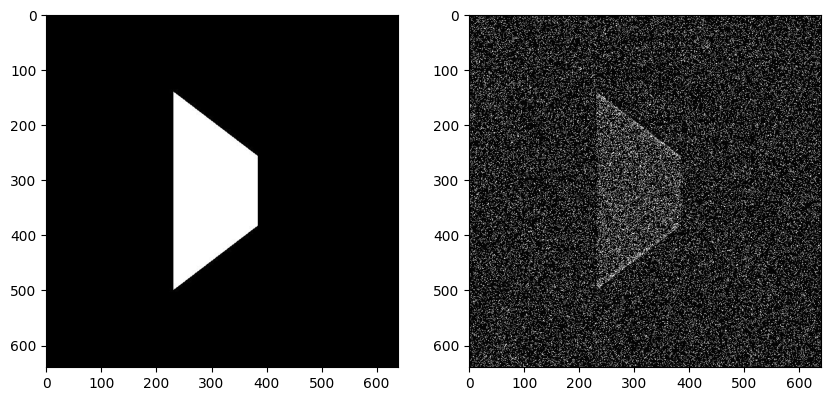

In [19]:
index = 3
mean_noise = 5
std_dev_noise = 5

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
noisy_img = add_noise(img,mean_noise,std_dev_noise)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(noisy_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut
# rajouter du bruit ça peut rendre très difficile la tâche
# typiquement, avec un peu de bruit le kmeans arrive à reconnaitre l'image (genre mean=0,std=1),
# mais dès que mean=5,std=5, kmeans ne reconnait plus rien...
# et c'est vrai qu'avec mean=5,std=5 le signal devient vraiment faible

### 3.3 A way to deblur images <a class="anchor" id="8"></a> [↑](#Table-of-contents)

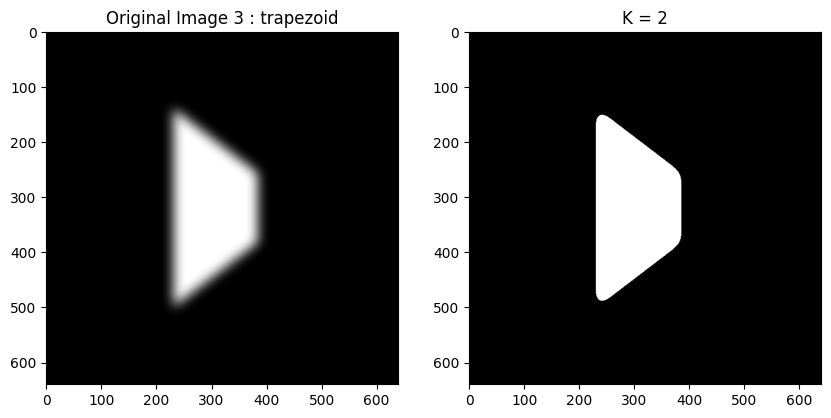

In [20]:
index = 3
K = 2 # Nombre de patternes autorisés
radius = 10
transpose = False # transpose l'image

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# Get the image
if transpose:
    Z = np.array(blurred_img).T.ravel().reshape(-1,1)
else:
    Z = np.array(blurred_img).ravel().reshape(-1,1)

# Get the category
cat = y_train[index]

res,label,center = kmeans(Z,K)

Z = Z.reshape(640,640)
res = res.reshape(640,640)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray')
ax[1].set_title(f'K = {K}')
plt.show()

In [ ]:
# à commenter
# là j'ai fait du kmeans non pas sur les lignes, non pas sur les colonnes, mais carrément sur toute l'image
# K=2 parce qu'on a que du noir et du blanc a priori
# mais on pourrait généraliser à un autre dataset avec K plus grand que 2

# à commenter
# on surmonte carrément le floutage, kmeans est un très bon moyen de résumer l'image!!

### 3.4 Rotate the image <a class="anchor" id="9"></a> [↑](#Table-of-contents)

In [21]:
def rotate_image(image, angle):
    """
    Rotate the input image by the specified angle.

    Args:
    image (PIL.Image): Input image.
    angle (float): Angle of rotation in degrees.

    Returns:
    PIL.Image: Rotated image as a NumPy array.
    """
    # Rotate the image
    rotated_image = image.rotate(angle, expand=False)

    return rotated_image

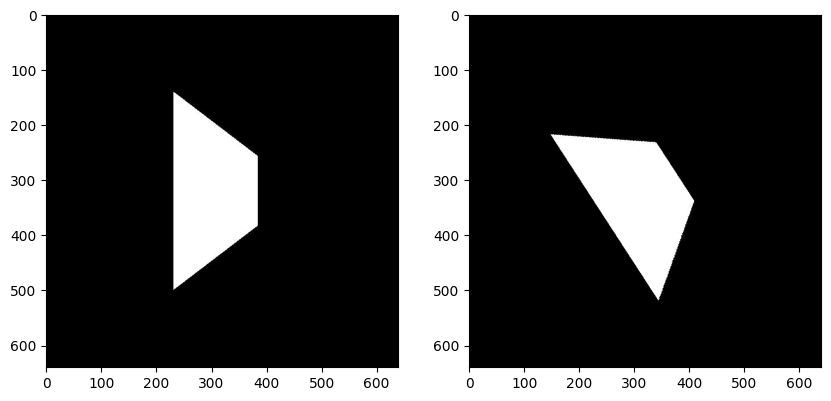

In [22]:
index = 3
angle = 33

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
rotated_image = rotate_image(img,angle)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(rotated_image, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

### 3.5 Move the image <a class="anchor" id="10"></a> [↑](#Table-of-contents)

In [23]:
def move_image(image, x, y):
    """
    Move the input image by the specified displacements in the x and y directions.

    Args:
    image (PIL.Image): Input image.
    output_image_path (str): Path to save the moved image.
    x (int): Displacement in the x direction.
    y (int): Displacement in the y direction.
    """
    # Move the image
    moved_image = Image.new("RGB", image.size)
    moved_image.paste(image, (x, y))

    return moved_image

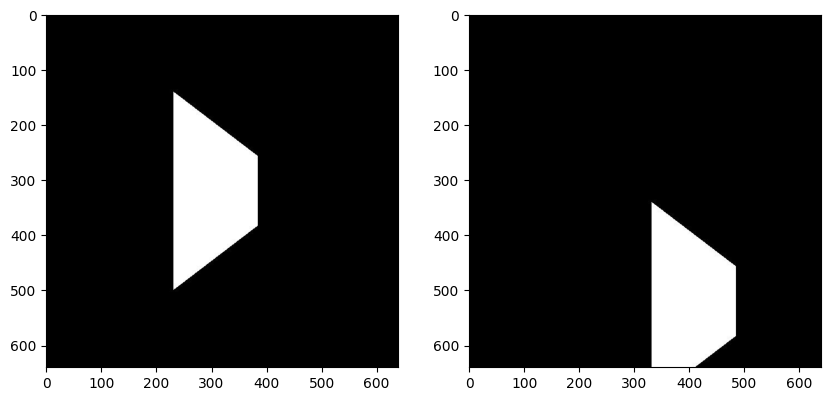

In [24]:
index = 3
x_move = 100
y_move = 200

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
moved_img = move_image(img,x_move,y_move)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(moved_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

### 3.6 Classe ImageK <a class="anchor" id="11"></a> [↑](#Table-of-contents)

On résume quelques-unes des features explorées à travers la classe `ImageK`.

On définit une image comme étant l'ensemble de paramètres :
- `K` (le nombre de labels)
- `res` (l'image après kmeans i.e. le vecteur de toutes les bandes)
- `label` (le vecteur des labels de chaque bande)
- `center` (le vecteur des K bandes)
- `ass` (un facteur d'assymétrie horizontale i.e. sur la lattitude)
- et de même via la transposée (d'où `assT` l'asymétrie verticale par exemple)

In [ ]:
class ImageK():
    def __init__(self,original,K=2,length=640,height=640):
        self.original = original.reshape(length,height)
        self.K = K
        self.length = length
        self.height = height
        self.res, self.label, self.center = kmeans(self.original.reshape(-1,1),K)
        self.res = self.res.reshape(length,height)

        # Asymétrie lattidudinale
        up, down = np.split(self.res,2)
        self.ass = np.abs(up-np.flip(down,0)).mean()

        # Asymétrie longitudinale
        up, down = np.split(self.res.T,2)
        self.assT = np.abs(up-np.flip(down,0)).mean()

        return

In [ ]:
index = 5
K = 2 # Nombre de patternes autorisés
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

img = np.array(img)
blurred_img = np.array(blurred_img)

In [ ]:
a = ImageK(blurred_img,K)

In [ ]:
a.ass

0.128536810481398

In [ ]:
a.assT

9.518150816147523

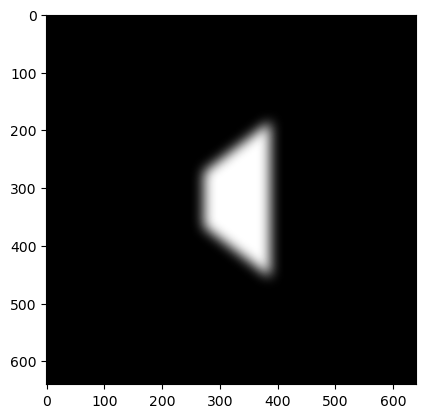

In [ ]:
plt.imshow(a.original, cmap='gray')

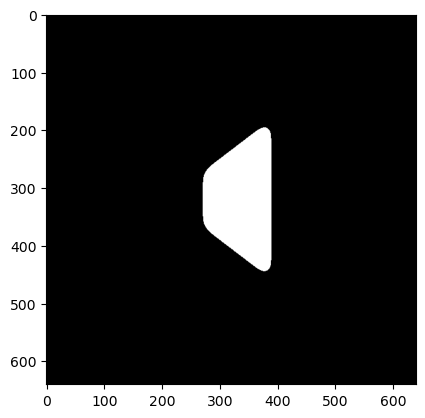

In [ ]:
plt.imshow(a.res, cmap='gray')

# 4. Basic Classifier <a class="anchor" id="classifier"></a>


In [32]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_flat, y_train, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict labels for the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

Accuracy: 0.3137254901960784
Balanced accuracy: 0.3681318681318681


# 5. Submission <a class="anchor" id="submission"></a>


## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [Shape And Patterns](http://www.ramp.studio/events/hotjupiter_datacamp2023). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/hotjupiter_datacamp2023/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard)) is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

In [ ]:
#!ramp-test --submission starting_kit